# Chapter 4. Multiple Regression: Rushing Yards Over Expected

In general, there are a plethora of variablesthat need to be controlled for when evaluating a football play. The way we do this is through multiple linear regression.

Multiple regression, estimates for the effect of several (multiple) predictors on a
single response using a linear combination (or regression) of the predictor
variables. Chapter 3 presented simple linear regression, which is a special case
of multiple regression. In a simple linear regression, two parameters exist: an
intercept (or average value) and a slope. These model the effect of a continuous
predictor on the response. In Chapter 3, the Python/R formula for your simple
linear regression had rushing yards predicted by an intercept and yards-to-go as
well as the intercept: rushing_yards ~ 1 + ydstogo.

However, you may be interested in multiple predictor variables. For example,
consider the multiple regression where you “correct” for down when estimating
expected rushing yards. You would use an equation (or formula) where rushing
yards are predicted by yards-to-go and down: rushing_yards ~ ydstogo + down.

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
pbp_py_run = \
    pbp_py\
    .query('play_type == "run" & rusher_id.notnull() &' +
            "down.notnull() & run_location.notnull()")\
    .reset_index()

In [4]:
pbp_py_run\
    .loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

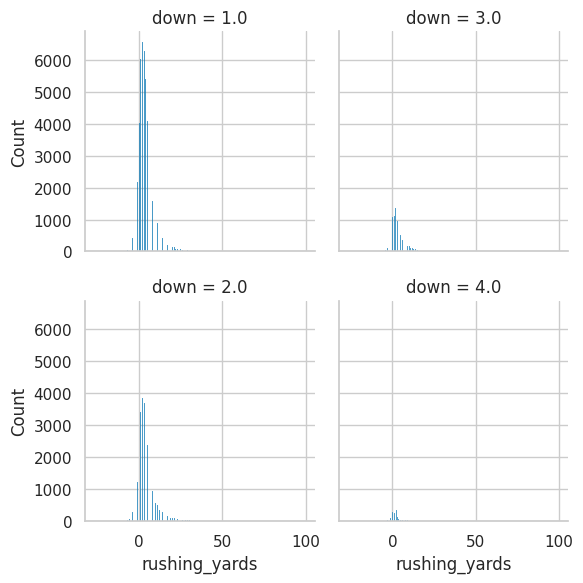

In [5]:
sns.set_theme(style="whitegrid", palette="colorblind")

# Change down to be an integer
pbp_py_run.down =\
    pbp_py_run.down.astype(str)

# Plot rushing yards by down
g = \
    sns.FacetGrid(data=pbp_py_run,
                    col="down", col_wrap=2);

g.map_dataframe(sns.histplot, x="rushing_yards");
plt.show();

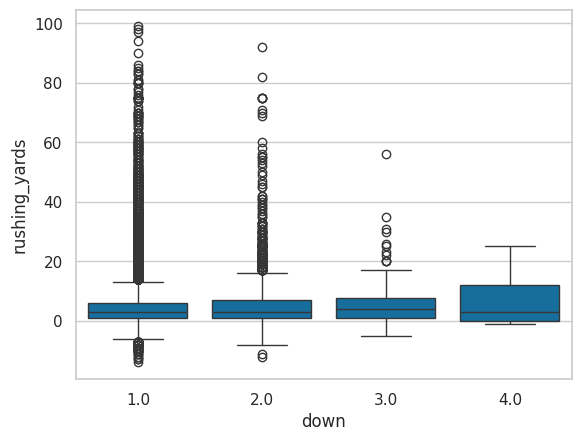

In [6]:
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"),
            x="down",
            y="rushing_yards");
plt.show()

This is an example of Simpson’s Paradox,
where relationships between variables change during different groupings of other
variables. Nonetheless, it’s clear that down affects the rushing yards on a play
and should be accounted for.

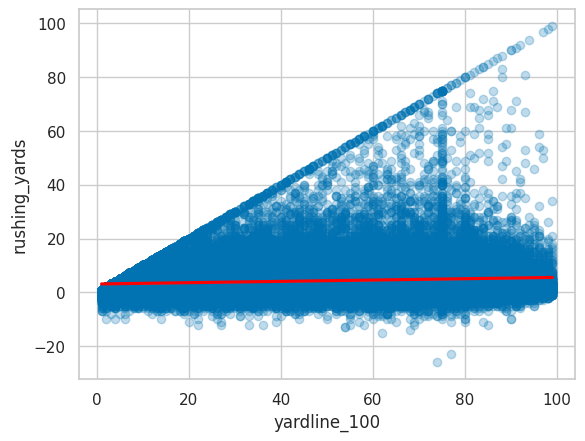

In [7]:
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
);

plt.show();

In [8]:
pbp_py_run_y100 =\
    pbp_py_run\
    .groupby("yardline_100")\
    .agg({"rushing_yards": ["mean"]})

pbp_py_run_y100.columns =\
    list(map("_".join, pbp_py_run_y100.columns))

pbp_py_run_y100.reset_index(inplace=True)

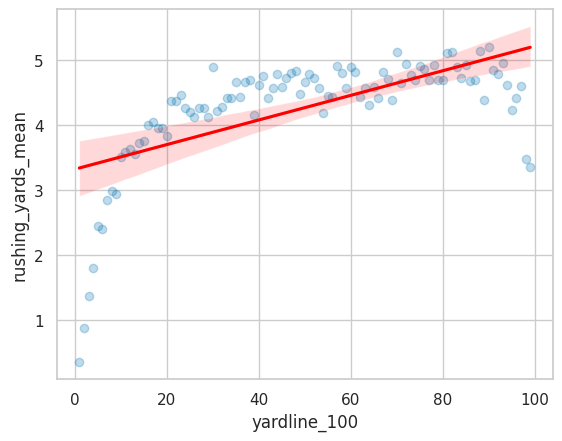

In [9]:
sns.regplot(data=pbp_py_run_y100,
    x="yardline_100",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
);
plt.show();

Running plays less than
about 15 yards to go are limited by distance because there is limited distance to
the endzone, and, tougher red zone defense. Likewise, plays with more than 90
yards to go are going out of your own end zone. So, defense will be trying hard
to force a safety and offense will be more likely to either punt or play
conservatively to avoid allowing a safety.

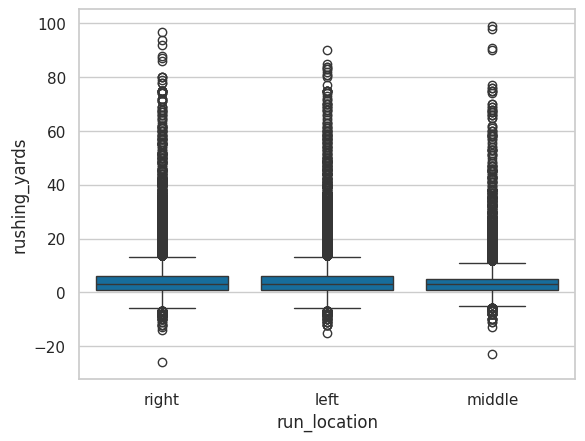

In [10]:
sns.boxplot(data=pbp_py_run,
            x="run_location",
            y="rushing_yards");
plt.show();

In [12]:
## Python
pbp_py_run_sd = \
    pbp_py_run\
    .groupby("score_differential")\
    .agg({"rushing_yards": ["mean"]}
)

pbp_py_run_sd.columns =\
    list(map("_".join, pbp_py_run_sd.columns))

pbp_py_run_sd.reset_index(inplace=True)

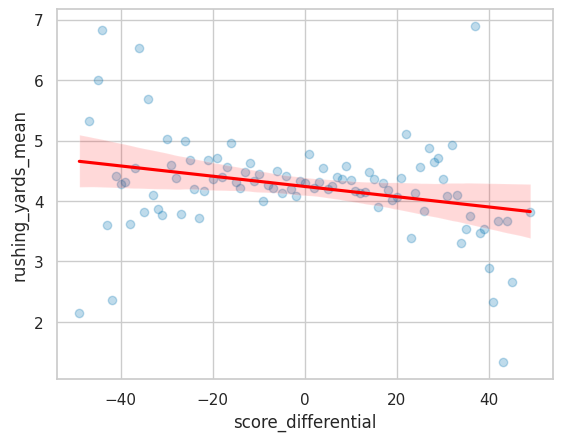

In [13]:
sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
);
plt.show();

In [14]:
pbp_py_run.down =\
    pbp_py_run.down.astype(str)

expected_yards_py =\
    smf.ols(
        data=pbp_py_run,
        formula="rushing_yards ~ 1 + down + ydstogo + " +
        "down:ydstogo + yardline_100 + " +
        "run_location + score_differential")\
        .fit()

pbp_py_run["ryoe"] =\
    expected_yards_py.resid

In [15]:
print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          3.39e-313
Time:                        18:04:02   Log-Likelihood:            -2.9760e+05
No. Observations:               91429   AIC:                         5.952e+05
Df Residuals:                   91417   BIC:                         5.953e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [18]:
ryoe_py =\
    pbp_py_run\
    .groupby(["season", "rusher_id", "rusher"])\
    .agg({
        "ryoe": ["count", "sum", "mean"],
        "rushing_yards": ["mean"]})

ryoe_py.columns =\
    list(map("_".join, ryoe_py.columns))

ryoe_py.reset_index(inplace=True)

ryoe_py =\
    ryoe_py\
    .rename(columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry",
    })\
    .query("n > 50")

ryoe_py.sort_values("ryoe_total", ascending=False).head(30)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,yards_per_carry
1869,2021,00-0036223,J.Taylor,332,471.407943,1.419903,5.454819
1349,2020,00-0032764,D.Henry,395,346.051690,0.876080,5.232912
1182,2019,00-0034796,L.Jackson,126,328.590215,2.607859,6.880952
1069,2019,00-0032764,D.Henry,386,311.754424,0.807654,5.145078
1382,2020,00-0033293,A.Jones,221,301.851344,1.365843,5.565611
2102,2022,00-0034796,L.Jackson,72,280.796271,3.899948,7.930555
1032,2019,00-0031687,R.Mostert,190,274.157609,1.442935,5.831579
294,2016,00-0033045,E.Elliott,342,273.669539,0.800203,5.137427
1466,2020,00-0034796,L.Jackson,118,258.135532,2.187589,6.415254
1787,2021,00-0034791,N.Chubb,228,248.189479,1.088550,5.521930


In [19]:
ryoe_py.sort_values("ryoe_per", ascending=False).head(30)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,yards_per_carry
2102,2022,00-0034796,L.Jackson,72,280.796271,3.899948,7.930555
1182,2019,00-0034796,L.Jackson,126,328.590215,2.607859,6.880952
1209,2019,00-0035228,K.Murray,53,137.666106,2.597474,6.867925
2238,2022,00-0036945,J.Fields,77,177.451455,2.304564,6.506494
1466,2020,00-0034796,L.Jackson,118,258.135532,2.187589,6.415254
348,2017,00-0027939,C.Newton,92,191.299297,2.079340,6.173913
1497,2020,00-0035228,K.Murray,70,143.932249,2.056175,6.057143
1784,2021,00-0034750,R.Penny,119,241.632542,2.030526,6.294117
1160,2019,00-0034400,J.Wilkins,51,97.784884,1.917351,6.019608
2036,2022,00-0033357,T.Hill,95,171.258326,1.802719,6.052631


In [20]:
cols_keep =\
    ["season", "rusher_id", "rusher",
    "ryoe_per", "yards_per_carry"]

# create current dataframe
ryoe_now_py =\
    ryoe_py[cols_keep].copy()

# create last-year's dataframe
ryoe_last_py =\
    ryoe_py[cols_keep].copy()

# rename columns
ryoe_last_py\
    .rename(columns = {'ryoe_per': 'ryoe_per_last',
                        'yards_per_carry': 'yards_per_carry_last'},
                        inplace=True)

# add 1 to season
ryoe_last_py["season"] += 1

In [21]:
ryoe_lag_py =\
    ryoe_now_py\
    .merge(ryoe_last_py,
            how='inner',
            on=['rusher_id', 'rusher',
            'season'])

In [22]:
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.347255
yards_per_carry,0.347255,1.000000


In [23]:
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.373311
ryoe_per,0.373311,1.000000
